<a href="https://colab.research.google.com/github/JUANBECERRIL003/EDP-2/blob/main/RICHARDSON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sympy as sp
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # necesario para 3D
from matplotlib import cm  # colormap

El problema a resolver es la **ecuación de calor 1D** con condiciones de frontera tipo Dirichlet:

$$
\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}
$$

Sujeto a:
* **Condiciones de Frontera (Dirichlet):** $u(0, t) = 0$ y $u(1, t) = 0$
* **Condición Inicial:** $u(x, 0) = f(x) = \sin(\pi x)$

Usamos el **Método Implícito de Richardson** (que en este caso es un método de Euler hacia atrás) con la discretización:

$$
\frac{u_i^{j+1} - u_i^j}{\Delta t} = \alpha \frac{u_{i-1}^{j+1} - 2u_i^{j+1} + u_{i+1}^{j+1}}{(\Delta x)^2}
$$

Reordenando los términos (con $j+1$ a la izquierda y $j$ a la derecha), obtenemos un sistema de ecuaciones lineales. Para este problema, el sistema toma la forma matricial:

$$
A \cdot \mathbf{u}^{j+1} = \mathbf{u}^j
$$

Donde $A$ es la matriz tridiagonal definida en el código (con $3$ en la diagonal y $-1$ en las subdiagonales) y $\mathbf{u}^j$ es el vector de la solución en el tiempo anterior.

In [ ]:
#Parámetros

# M: Número de nodos internos (puntos en x sin contar las fronteras)
M = 9
"""
dx: Tamaño del paso en el espacio (delta x)
El dominio es [0, 1]. Con M=9 nodos internos, tenemos M+1 = 10 subintervalos."""
dx = 1 / (M + 1)
"""
Vector de nodos en x (solo los puntos internos)
np.linspace(inicio, fin, num_puntos)
Queremos 9 puntos: 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9
El punto inicial es dx (o 0.1) y el final es M*dx (o 0.9)"""
x_nodos = np.linspace(dx, M * dx, M)

print(f"Número de nodos internos M: {M}")
print(f"Paso espacial dx: {dx}")
print(f"Nodos en x (internos): \n{x_nodos}")

Número de nodos internos M: 9
Paso espacial dx: 0.1
Nodos en x (internos): 
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


In [ ]:
def f(x):
    """
    Esta es la condición inicial del problema, u(x, 0) = f(x)
    Se usa np.sin y np.pi de la librería NumPy para que pueda operar sobre vectores completos
    (como x_nodos) de forma eficiente."""
    return np.sin(np.pi * x)

In [ ]:
#Ejercicio 1: Codificar la matriz A de manera simple
"""
1.- Creamos una matriz M x M (9x9) llena de ceros.
2.- Llenamos la diagonal principal con 3.
3.- Llenamos las diagonales superior e inferior con -1."""

# 1. Crear matriz de ceros 9x9
A = sp.zeros(M)

# 2. Llenar la diagonal principal (k=0) con 3
for i in range(M):
    A[i, i] = 3

# 3. Llenar las subdiagonales (k=1 y k=-1) con -1
for i in range(M - 1):
    A[i, i + 1] = -1  # Diagonal superior
    A[i + 1, i] = -1  # Diagonal inferior
A

Matrix([
[ 3, -1,  0,  0,  0,  0,  0,  0,  0],
[-1,  3, -1,  0,  0,  0,  0,  0,  0],
[ 0, -1,  3, -1,  0,  0,  0,  0,  0],
[ 0,  0, -1,  3, -1,  0,  0,  0,  0],
[ 0,  0,  0, -1,  3, -1,  0,  0,  0],
[ 0,  0,  0,  0, -1,  3, -1,  0,  0],
[ 0,  0,  0,  0,  0, -1,  3, -1,  0],
[ 0,  0,  0,  0,  0,  0, -1,  3, -1],
[ 0,  0,  0,  0,  0,  0,  0, -1,  3]])

Resolvemos el Ejercicio 1. Creamos la matriz programáticamente. Este método es más claro y robusto que escribirla a mano.

Usamos sp.zeros(M) para crear una matriz cuadrada de $9x9$. Luego, un bucle for i in range(M) recorre la diagonal principal $(A[i,i])$ para poner los 3. Un segundo bucle for i in range(M-1) (que se detiene uno antes) rellena las diagonales superior $(A[i, i+1])$ e inferior $(A[i+1, i])$ con $-1$.

In [ ]:
#Ejercicio 2: Definir b de manera simple

# Solución usando un bucle for
b_lista = []
for i in range(M): # Iteramos M (9) veces
    # Calculamos f(x) en el nodo x_nodos[i] y lo añadimos a la lista
    valor = f(x_nodos[i])
    b_lista.append(valor)

#Convertimos la lista de Python a una Matriz de SymPy
b = sp.Matrix(b_lista)

"""
Forma alternativa usando list comprehension:
b = sp.Matrix([f(xi) for xi in x_nodos])

# Imprimimos b para verificar que es igual al original"""
b

Matrix([
[0.309016994374947],
[0.587785252292473],
[0.809016994374947],
[0.951056516295154],
[              1.0],
[0.951056516295154],
[0.809016994374947],
[0.587785252292473],
[0.309016994374948]])

In [ ]:
def richardson(A, b, j):
    """
    Resuelve el sistema A*u = b iterativamente j veces (pasos de tiempo).

    Parámetros:
    A (sp.Matrix): La matriz tridiagonal del sistema.
    b (sp.Matrix): El vector de condición inicial u(x, 0).
    j (int): El número de pasos de tiempo (iteraciones) a calcular.

    Retorna:
    S (np.array): Una matriz donde cada fila es la solución u(x, t)
    en un paso de tiempo t.
    """

    # S: Matriz para almacenar los resultados de todos los pasos
    S = []
    """
    b_1: Es el vector de la solución en el paso j.
    Lo inicializamos con b.copy(), que es u(x, 0).
    Usamos .copy() para no modificar el vector 'b' original."""
    b_1 = b.copy()

    #Bucle de tiempo
    """
    # range(j+1) para incluir el estado inicial (j=0) y
    # calcular j pasos adicionales."""
    for i in range(j + 1):
        """
        1.- Guardar la solución actual (b_1) en la matriz S
        Se convierte a np.array, .float() y .reshape(-1) para asegurar que sea un vector fila de números."""
        S.append(np.array(b_1, dtype=float).reshape(-1))
        """
        2.- Resolver el sistema A * u(j+1) = u(j)
        A.LUsolve(b_1) resuelve para u(j+1)
        (El nuevo b_1 es la solución del sistema)"""
        sol = A.LUsolve(b_1)

        # 3. Actualizar b_1 para la siguiente iteración
        b_1 = sol
    """
    Convertimos la lista de listas 'S' en una matriz de NumPy para que Matplotlib pueda usarla fácilmente."""
    return np.array(S)

"El ejercicio 4 está más adelante :)"

### Respuesta al Ejercicio 5

**No, no podemos hacer una simplificación.**

Es **necesario** resolver el sistema completo de 9x9 en cada paso de tiempo.

* **Razón:** Estamos usando un **método implícito**.
* **Explicación:** En la ecuación de discretización, los valores *nuevos* $u_{i-1}^{j+1}$, $u_i^{j+1}$ y $u_{i+1}^{j+1}$ (todos en el tiempo $j+1$) están en el mismo lado de la ecuación.
* **Consecuencia:** El valor de $u_i^{j+1}$ depende de sus vecinos ($u_{i-1}^{j+1}$ y $u_{i+1}^{j+1}$) *en el mismo instante de tiempo*. No podemos calcular un punto sin conocer los otros.
* **Conclusión:** Esto crea un sistema de 9 ecuaciones lineales simultáneas (una para cada nodo $i$), que es precisamente lo que representa la matriz $A$ de 9x9. Debemos resolver este sistema $A \cdot \mathbf{u}^{j+1} = \mathbf{u}^j$ para encontrar todos los valores $\mathbf{u}^{j+1}$ a la vez.

In [ ]:
#Definición de Parámetros de Tiempo

# j: Número de pasos en el tiempo
j = 20
"""
dt: Tamaño del paso en el tiempo (delta t)
Lo elegimos para que t_final = 0.6 (como en el código original)"""
dt = 0.03
t_final = j * dt
"""
Corremos la simulación para j pasos de tiempo
U_interna tendrá forma (j+1, M) = (21, 9)"""
U_interna = richardson(A, b, j)

#Respuesta al Ejercicio 6: Corrección de Ejes y Datos
"""
1.- Corrección del eje x:
El 'detalle de precisión' es que la gráfica debe incluir las fronteras.
El código original usaba np.linspace(0, 1, 9), lo cual es incorrecto.
Necesitamos un vector con M+2 = 11 puntos (incluyendo x=0 y x=1).
0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0 """
x_grafica = np.linspace(0, 1, M + 2)
"""
2.- Corrección del eje y (tiempo):
El eje 'y' representa el tiempo. Va de 0 a t_final.
Debe tener j+1 puntos (igual que las filas de U_interna)."""
y_tiempo = np.linspace(0, t_final, j + 1)
"""
3.- Corrección de la Matriz U:
U_interna (21, 9) solo tiene los nodos internos.
Necesitamos añadir las columnas de ceros de las fronteras (en x=0 y x=1).
Creamos U_completa con ceros, de forma (21, 11)"""
U_completa = np.zeros((j + 1, M + 2))

# Copiamos los datos internos (columnas 1 a 9) en la matriz completa
U_completa[:, 1:-1] = U_interna

#Creación de la Malla

# Usamos los ejes corregidos para crear la malla para las gráficas 3D
X, Y = np.meshgrid(x_grafica, y_tiempo)

# Imprimimos las formas para verificar
print(f"Forma de U_interna (calculada): {U_interna.shape}")
print(f"Forma de U_completa (para gráfica): {U_completa.shape}")
print(f"Forma de X (malla): {X.shape}")
print(f"Forma de Y (malla): {Y.shape}")

Forma de U_interna (calculada): (21, 9)
Forma de U_completa (para gráfica): (21, 11)
Forma de X (malla): (21, 11)
Forma de Y (malla): (21, 11)


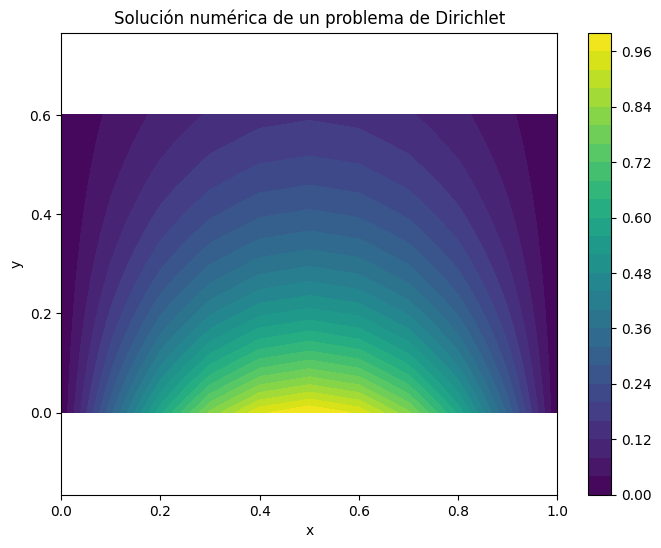

In [ ]:
# Mapa de colores
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, U_completa, levels=25, cmap=cm.viridis)
plt.colorbar(contour)
plt.title('Solución numérica de un problema de Dirichlet')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

### Explicación del Mapa de Colores (Gráfica 2D)

Esta gráfica muestra la evolución de la temperatura $u(x, t)$ como un mapa de calor:

* **Eje X (Posición):** Representa la barra en el espacio, desde $x=0$ hasta $x=1$.
* **Eje Y (Tiempo):** Representa el tiempo $t$, desde $t=0$ hasta $t=0.6$.
* **Color (Temperatura):** La barra de color a la derecha indica el valor de $u$.
    * **Amarillo:** Temperatura alta (valor cercano a 1.0).
    * **Morado oscuro:** Temperatura baja (valor cercano a 0.0).

**Interpretación:**
Se puede ver claramente la condición inicial $u(x, 0) = \sin(\pi x)$ en la parte inferior ($y=0$), que es la zona más caliente (amarilla). A medida que el tiempo avanza (hacia arriba en el eje Y), el calor se disipa hacia los extremos, y la barra se enfría. Las condiciones de frontera $u(0,t)=0$ y $u(1,t)=0$ se observan como las franjas moradas constantes en los bordes izquierdo y derecho.

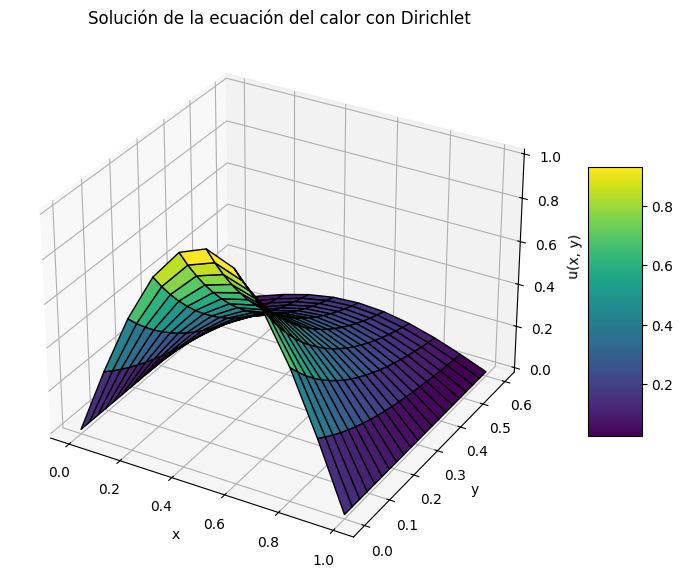

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, U_completa, cmap=cm.viridis, edgecolor='k')
ax.set_title('Solución de la ecuación del calor con Dirichlet')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u(x, y)')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

### Explicación de la Superficie (Gráfica 3D)

Esta gráfica representa la misma solución, pero como una superficie en tres dimensiones:

* **Eje X (Posición):** La barra en el espacio, de $x=0$ a $x=1$.
* **Eje Y (Tiempo):** El tiempo $t$, de $t=0$ a $t=0.6$.
* **Eje Z (Temperatura):** La altura de la superficie, $u(x, y)$, que representa la temperatura.

**Interpretación:**
Esta vista nos da una mejor intuición de la "forma" de la solución. Comienza como una onda $\sin(\pi x)$ en el plano "Y=0". A medida que el tiempo $t$ (eje Y) aumenta, la altura de la superficie (eje Z) disminuye, mostrando cómo la temperatura decae exponencialmente hacia cero. Los bordes en $x=0$ y $x=1$ permanecen "planos" en $Z=0$ durante todo el tiempo, cumpliendo las condiciones de frontera de Dirichlet.

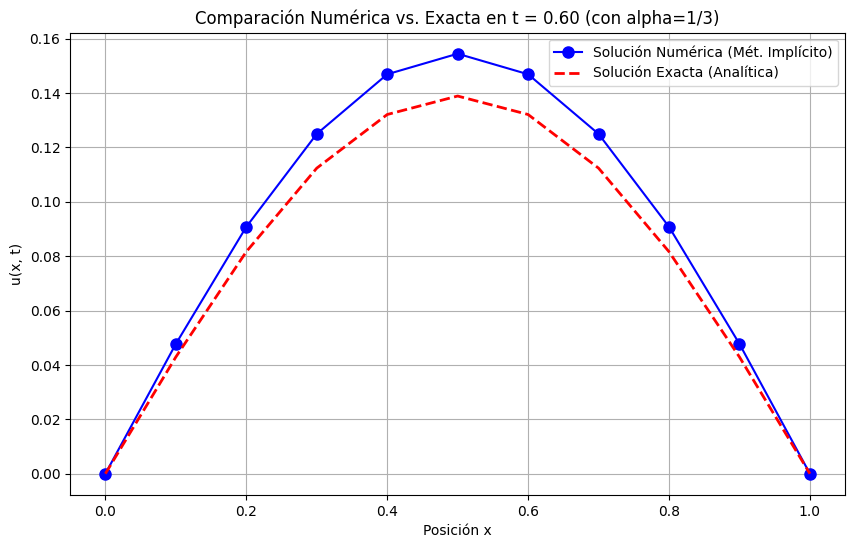

In [ ]:
#Ejercicio 4:
"""
r = (alpha * dt) / (dx^2)
La matriz dada en el código de guía (3 y -1) IMPLICA r=1.
Con dt=0.03 y dx=0.1, esto significa:
1 = (alpha * 0.03) / (0.1^2) = alpha * 3
Por lo tanto, alpha = 1/3"""
alpha_problema = 1/3

# La solución analítica exacta es:
# u(x, t) = exp(-alpha * pi^2 * t) * sin(pi * x)
def solucion_exacta(x, t, alpha):
    return np.exp(-alpha * (np.pi**2) * t) * np.sin(np.pi * x)

#Comparación en el último paso de tiempo

# 1.- Tomar la solución numérica en el último tiempo (t = 0.6)
t_final = y_tiempo[-1] # Es 0.6
solucion_numerica_final = U_completa[-1, :]
"""
2.- Calcular la solución exacta en ese mismo tiempo
Usamos x_grafica (de 0 a 1, con 11 puntos) y el alpha_problema correcto"""
solucion_exacta_final = solucion_exacta(x_grafica, t_final, alpha_problema)

#Gráfica de Comparación
%matplotlib inline
plt.figure(figsize=(10, 6))
plt.title(f"Comparación Numérica vs. Exacta en t = {t_final:.2f} (con alpha=1/3)")
plt.plot(x_grafica, solucion_numerica_final, 'bo-', label='Solución Numérica (Mét. Implícito)', markersize=8)
plt.plot(x_grafica, solucion_exacta_final, 'r--', label='Solución Exacta (Analítica)', linewidth=2)
plt.xlabel('Posición x')
plt.ylabel('u(x, t)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# GIF
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# Crear la figura y los ejes para la animación
fig, ax = plt.subplots(figsize=(8, 5))

# Dibujar el primer cuadro (el estado inicial, t=0)
# Usamos x_grafica y la primera fila [0, :] de U_completa
line, = ax.plot(x_grafica, U_completa[0, :], lw=2, color='blue')
"""
Establecer límites fijos para el eje Y
Esto evita que la gráfica "salte"
Usamos 1.1*max para dar un poco de espacio en la parte superior"""
ax.set_ylim([np.min(U_completa) - 0.1, np.max(U_completa) * 1.1])

ax.set_xlabel('Posición x')

ax.set_ylabel('u(x, t)')
title = ax.set_title(f'Evolución en el tiempo t = {y_tiempo[0]:.3f}')
ax.grid(True)

# Esta función se llama para cada 'frame' (cada paso de tiempo k)

def update(k):
    # k es el número de frame (irá de 0 a j)

    # Actualizar los datos Y de la línea con la fila k de U_completa
    line.set_ydata(U_completa[k, :])

    # Actualizar el título con el tiempo correspondiente (y_tiempo[k])
    title.set_text(f'Evolución en el tiempo t = {y_tiempo[k]:.3f}')

    return line, title

#Crear y Guardar la Animación

# j+1 es el número total de frames (que es len(y_tiempo))
num_frames = j + 1
anim = FuncAnimation(fig, update, frames=num_frames, interval=50, blit=True)
writer = PillowWriter(fps=20)

# Guardar el archivo
anim.save("animacion_calor.gif", writer=writer)

plt.close(fig) # Cerrar la figura para que no se muestre estática aquí

print("¡Listo! Animación guardada como 'animacion_calor.gif'")

¡Listo! Animación guardada como 'animacion_calor.gif'
